# Task 1: Linear Triangulation [15]

**Please go through the notebook once before beginning working on it!**

The goal of this section is to understand the geometric relationships between multiple views of a scene. Linear triangulation is a fundamental step in 3D reconstruction pipelines. It involves estimating the 3D coordinates of points in a scene using projections onto two or more images taken from different camera perspectives. This process is essential because it allows us to map the 2D image features into the 3D world, providing a foundation for building more detailed 3D models.

In this notebook you will:
1. Pre-process the dataset and extract key features from the images using feature detection methods such as **SIFT** or **ORB**.
2. Match these features across image pairs to identify corresponding points.
3. Compute the fundamental and essential matrices to estimate the relative poses of the cameras.
4. Use linear triangulation to determine the 3D coordinates of a point in space and visualize it.

<span style="color: red">**Submission Guidelines:**</span> Only one member of each group has to submit the file on LMS. The name of the file should be your group number. For example, if you are Group 1 then the file name should be **G01_Deliverable1.ipynb**. If you are unsure about your group number, then you can confirm it in the [sheet](https://docs.google.com/spreadsheets/d/1vN6JOLDWoFR5BnXTr0lMYGv_e9VzyAbqSUqf4VdjCQI/edit?gid=0#gid=0) 

#### Imports

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# add imports here
import pandas as pd

### Dataset
We will use the [Heritage-Recon](https://drive.google.com/drive/folders/1eZvmk4GQkrRKUNZpagZEIY_z8Lsdw94v) dataset, which contains sets of images of various landmarks captured from multiple angles. You can choose one landmark for your project and use its dataset for this task.

If you go through the dataset, you will find the images for your landmark in the **dense/images** folder. There are also some other important files that you will see. For example, the root directory of the brandenburg gate dataset contains the **brandenburg_gate.ply**, which is the actual 3D model generated from the dataset. You will generating something similar for the next deliverable as well.

The **neuralsfm** folder contains three key **.bin** files, which are binary files commonly used in Structure from Motion (SfM) pipelines like COLMAP for storing 3D reconstruction data:
1. cameras.bin: stores information about the cameras used in the SfM process. It includes intrinsic parameters, such as focal lengths and principal points, as well as extrinsic parameters that define the camera's position and orientation.
2. images.bin: contains the images’ pose information within the 3D space. It also includes 2D keypoints detected in each image and their associations with 3D points. This file is crucial for understanding where each image is located in the reconstructed scene.
3. points3D.bin: holds information about the reconstructed 3D points, including their 3D coordinates, color, and visibility across images. It essentially represents the sparse point cloud of the scene, where each point correlates with specific 2D keypoints in the images.

The **semantic_maps** folder contains .npz files that store semantic segmentation data in a compressed format. Each .npz file corresponds to a semantic map or segmentation mask for a particular image, with classes or labels encoded as numerical values.

### Loading in our data

Load in 3 different images from the images folder and display them.

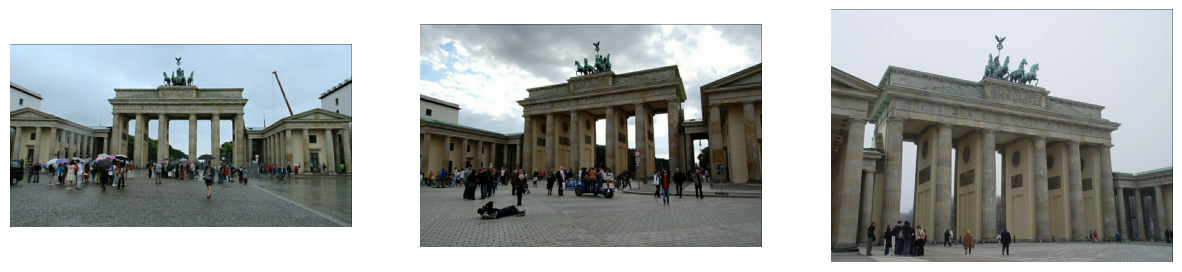

In [2]:
### Loading in our data

# Load in 3 different images from the images folder and display them.
# your code here

data_dir = 'Dataset/brandenburg_gate/dense/images'
img1 = '00289298_7642283248.jpg'
img2 = '04800984_8342094434.jpg'
img3 = '18631103_2784294103.jpg'

img1 = cv2.imread(os.path.join(data_dir, img1))
img2 = cv2.imread(os.path.join(data_dir, img2))
img3 = cv2.imread(os.path.join(data_dir, img3))

plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(132)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(133)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



#### Pre-processing

If you go through the images in the dataset you will notice images with varying dimensions, angles, brightness levels etc. For us to effectively use our dataset, we first need to pre-process our images. Pre-processing ensures that the images are prepared consistently for feature detection, matching, and camera pose estimation.

Some helper functions that might be useful.

In [3]:
def get_img_paths(folder_pth):
    """Returns a list containing filenames of all jpg files in folder_pth"""
    jpg_files = []

    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            # uncomment the line below if you want to include the entire path in the filename
            # filename = os.path.join(folder_pth, filename)
            jpg_files.append(filename)

    return jpg_files


def load_images(folder_pth):
    """Loads all images in folder_path"""
    images = []
    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_pth, filename))
            images.append(img)

    return images


def resize_image(img, size=(800, 600)):
    """Resizes image to a specified size."""
    return cv2.resize(img, size)


def convert_to_grayscale(img):
    """Converts an image to grayscale."""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# you can add other functions here as well.

Now, load the images from the dataset folder, apply the pre-processing steps, and display few of the pre-processed images to verify. I have included a few types of pre-processing methods above, but you can use any other method as well that you believe might be helpful. Give a two-liner explaination for your pre-processing choices.

**Ans:**

In [4]:
# loaded_images = load_images(data_dir)
# resized_images = [resize_image(img) for img in loaded_images]
# gray_images = [convert_to_grayscale(img) for img in resized_images]

# #display 4 random images
# plt.figure(figsize=(15, 15))
# for i in range(4):
#     plt.subplot(2, 2, i+1)
#     plt.imshow(gray_images[i], cmap='gray')
#     plt.axis('off')

# plt.show()

preprocessed_images = []
for img in [img1, img2, img3]:
    img = resize_image(img)
    img = convert_to_grayscale(img)
    preprocessed_images.append(img)


### Feature Detection

The goal is to identify distinct and robust points in the images that can be matched across different views. These feature points are the key to establishing correspondences between images.

There are several feature detection algorithms such as SIFT, SURF, or ORB available in the cv2 library. When using any of the algorithms, be sure to check the format of the image that it accepts.

Using any feature detection algorithm, extract the features from two images and display the images with the features higlighted on them. Here is an example:

<img src="assets/feature_detection.png" alt="My Image" width="800"/>

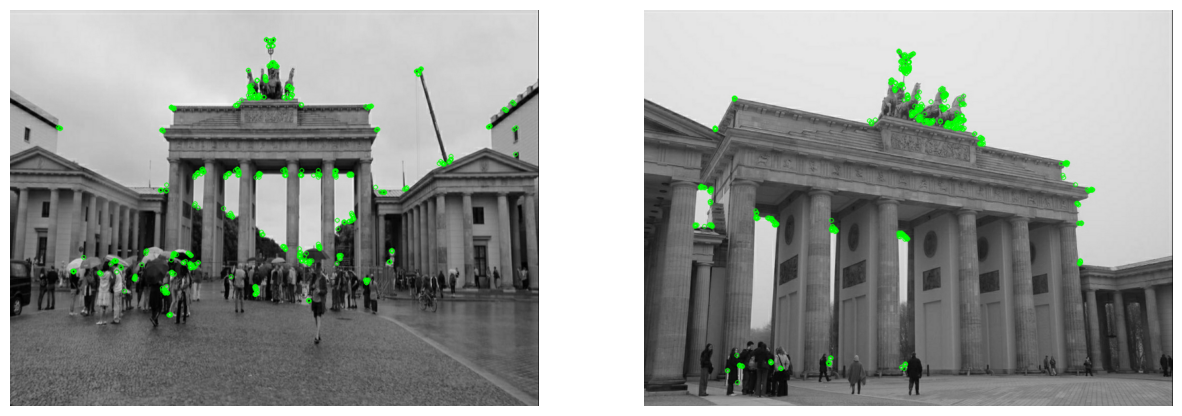

In [5]:
METHOD = 'orb' # or 'orb'

# Feature detection using SIFT or ORB
def feature_detection(img, method='sift'):
    if method == 'sift':
        detector = cv2.SIFT_create()
    elif method == 'orb':
        detector = cv2.ORB_create()
    else:
        raise ValueError('Invalid method. Choose either sift or orb')
    
    kp, des = detector.detectAndCompute(img, None)

    return kp, des

# Now, apply the feature detection methods to the pre-processed images and display the detected features.
# your code here

features_detected = []
keypoint_descriptors = []


# images = [preprocessed_images[0], preprocessed_images[2]]
for img in preprocessed_images:
    # Detect features using SIFT
    kp, des = feature_detection(img, method=METHOD) #check out orb too
    keypoint_descriptors.append((kp, des))
    # or draw circles
    img = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=0)
    features_detected.append(img)

plt.figure(figsize=(15, 15))
for i, img in enumerate([features_detected[0], features_detected[2]]):
    plt.subplot(1, 2, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.show()


### Feature Matching

Feature matching is a crucial step in 3D reconstruction because it helps find corresponding points between different images. Once you've detected the keypoints and descriptors using a feature detector, the next step is to match these descriptors across pairs of images.


Use the keypoints and descriptors extracted above for the two images and match the features across the two images. You can use this as a reference image:

<img src="assets/feature_matching.png" alt="My Image" width="800"/>

In [6]:
def feature_matching_bf(des1, des2, method='sift'):
    # Create a BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True) if method == 'sift' else cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # Match descriptors
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    #bf.knnMatch(des1, des2, k=2) can also be used to get k best matches
    
    return matches


def feature_matching_flann(des1, des2):

    des1 = np.float32(des1)
    des2 = np.float32(des2)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50) # higher values give better precision but are slower

    # Create a FLANN matcher object
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors
    matches = flann.knnMatch(des1, des2, k=2)
    matchesMask = [[0, 0] for i in range(len(matches))]

    # Apply ratio test and return matches as a list
    for m, n in matches:
        if m.distance < 0.9 * n.distance:  # threshold ratio
            matchesMask[i] = [1, 0]

    return matches,matchesMask

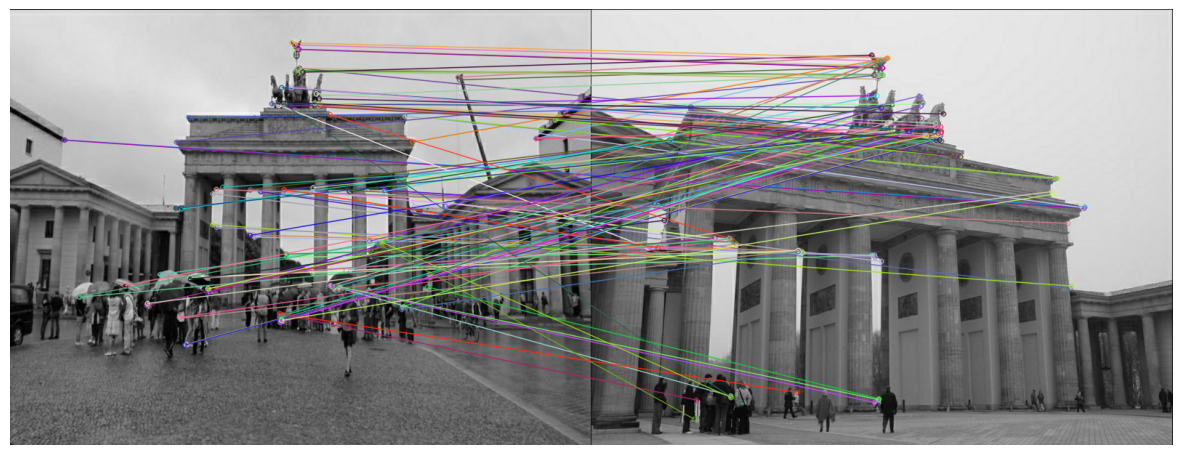

In [7]:
# Now, apply the feature matching methods to the detected features and display the matched features.

#find matches between the first and third images

first_image_kp, first_image_des = keypoint_descriptors[0]
# second_image_kp, second_image_des = keypoint_descriptors[1]
third_image_kp, third_image_des = keypoint_descriptors[2]


bf_matches = feature_matching_bf(first_image_des, third_image_des, method=METHOD)  # get matches between first and third images

# Draw matches
img_display = cv2.drawMatches(preprocessed_images[0], first_image_kp, preprocessed_images[2], third_image_kp, bf_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
    


# FLANN matching

# flann_matches, masks = feature_matching_flann(first_image_des, third_image_des)

# # Draw FLANN matches
# draw_params = dict(matchColor = (0, 255, 0), singlePointColor = (255, 0, 0), matchesMask=masks ,flags = cv2.DrawMatchesFlags_DEFAULT)
# img_display_flann = cv2.drawMatchesKnn(preprocessed_images[0], first_image_kp, preprocessed_images[2], third_image_kp, flann_matches, None, **draw_params)

# plt.figure(figsize=(15, 15))
# plt.imshow(cv2.cvtColor(img_display_flann, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()



### Camera Pose Estimation

Camera pose estimation involves determining the relative position and orientation (i.e., rotation and translation) of the camera between two views. This is typically done by estimating the essential matrix or fundamental matrix between two sets of matched keypoints, and then decomposing these matrices to recover the camera pose.

So essentially:
1. Find the **fundamental matrix (F)** using the matched keypoints.
2. Decompose the **essential matrix (E)** into the rotation and translation components.
3. Use epipolar geometry to verify or refine the solution.

You can use the lecture slides as reference for computing these. 

Calculate the fundemental and essential matrices. Use these to recover the translation and rotation matrices.

In [8]:
#Load the camera parameters and image txt files gerenated by COLMAP from bin files

path = 'Dataset/brandenburg_gate/ColmapParsedFiles'

camera_params = pd.read_csv(os.path.join(path, 'cameras.txt'), sep=' ', header=None, skiprows=3, names=['camera_id', 'model', 'width', 'height', 'focal_length_x', 'focal_length_y', 'principal_point_x', 'principal_point_y'])
print(camera_params.head())

#for images.txt more parsing is needed
images_metadata = []
images_points2d = []

with open(os.path.join(path, 'images.txt'), 'r') as file:
    lines = file.readlines()

    #process 2 lines at a time because first line contains the column values while second contains POINTS2D[] as (X, Y, POINT3D_ID)
    for i in range(0, len(lines), 2):
        if lines[i].startswith('#'):
            continue

        #parse the first line
        metadata = lines[i].strip().split()
        image_id = int(metadata[0])
        qw, qx, qy, qz = map(float, metadata[1:5])
        tx, ty, tz = map(float, metadata[5:8])
        camera_id = int(metadata[8])
        name = metadata[9]

        images_metadata.append([image_id, qw, qx, qy, qz, tx, ty, tz, camera_id, name])

        #parse the second line uncomment if needed
        # points2d_line = lines[i+1].strip().split()
        # points2d_list = []

        # for j in range(0, len(points2d_line), 3):
        #     x, y, point3d_id = map(float, points2d_line[j:j+3])
        #     points2d_list.append((x, y, point3d_id))

        # images_points2d.append(points2d_list)
        

images = pd.DataFrame(images_metadata, columns=['image_id', 'qw', 'qx', 'qy', 'qz', 'tx', 'ty', 'tz', 'camera_id', 'name'])
print(images.head())

   camera_id    model  width  height  focal_length_x  focal_length_y  \
0        341  PINHOLE   1053     779     1290.895874     1290.895874   
1        708  PINHOLE   1056     692     1108.709229     1108.709229   
2        707  PINHOLE   1011     674     1246.663208     1246.663208   
3       1363  PINHOLE   1033     685     1248.857788     1248.857788   
4        706  PINHOLE   1062     683      927.347595      927.347595   

   principal_point_x  principal_point_y  
0              526.5              389.5  
1              528.0              346.0  
2              505.5              337.0  
3              516.5              342.5  
4              531.0              341.5  
   image_id        qw        qx        qy        qz        tx        ty  \
0       341  0.998747 -0.016438 -0.047120 -0.003779 -0.083426 -0.513677   
1       708  0.999171  0.010186  0.036741 -0.014307 -1.277541 -0.253808   
2       707  0.977690  0.063006 -0.198312  0.028714  1.815359  0.155180   
3      1363  0.

In [9]:
#from the images dataframe find the camera_id of the two images we are working with using the image name
img1_name = '00289298_7642283248.jpg'
# # img2_name = '04800984_8342094434.jpg'
img3_name = '18631103_2784294103.jpg'


#convert the above into a function
def get_camera_params(images, camera_params, img_name):
    img_camera_id = images[images['name'] == img_name]['camera_id'].values[0]
    img_camera_intrinsic_params = camera_params[camera_params['camera_id'] == img_camera_id]
    img_rotation_quaternion = images[images['name'] == img_name][['qw', 'qx', 'qy', 'qz']].values[0]
    img_translation = images[images['name'] == img_name][['tx', 'ty', 'tz']].values[0]

    return img_camera_intrinsic_params, img_rotation_quaternion, img_translation

img1_camera_intrinsic_params, img1_rotation_quaternion, img1_translation = get_camera_params(images, camera_params, img1_name)
# img2_camera_intrinsic_params, img2_rotation_quaternion, img2_translation = get_camera_params(images, camera_params, img2_name)
img3_camera_intrinsic_params, img3_rotation_quaternion, img3_translation = get_camera_params(images, camera_params, img3_name)



print("Image 1 Values:\n")
print("Camera Intrinsic Parameters:\n ", img1_camera_intrinsic_params)
print("Rotation Quaternion:\n ", img1_rotation_quaternion)
print("Translation:\n ", img1_translation)


print("\n")
# print("Image 2 Values\n:")
# print("Camera Intrinsic Parameters: ", img2_camera_intrinsic_params)
# print("Rotation Quaternion: ", img2_rotation_quaternion)
# print("Translation: ", img2_translation)

print("\n")
print("Image 3 Values:\n")
print("Camera Intrinsic Parameters:\n ", img3_camera_intrinsic_params)
print("Rotation Quaternion:\n ", img3_rotation_quaternion)
print("Translation:\n ", img3_translation)

Image 1 Values:

Camera Intrinsic Parameters:
       camera_id    model  width  height  focal_length_x  focal_length_y  \
636          1  PINHOLE   1077     575      882.229065      882.229065   

     principal_point_x  principal_point_y  
636              538.5              287.5  
Rotation Quaternion:
  [ 0.99815054  0.05908324 -0.01343122 -0.00492741]
Translation:
  [-0.64440377  0.06674512  1.24194197]




Image 3 Values:

Camera Intrinsic Parameters:
       camera_id    model  width  height  focal_length_x  focal_length_y  \
742        201  PINHOLE   1055     780     1178.065063     1178.065063   

     principal_point_x  principal_point_y  
742              527.5              390.0  
Rotation Quaternion:
  [ 0.95796853 -0.01331306 -0.28209827  0.05039462]
Translation:
  [ 3.54913964 -0.21232175 -0.37088443]


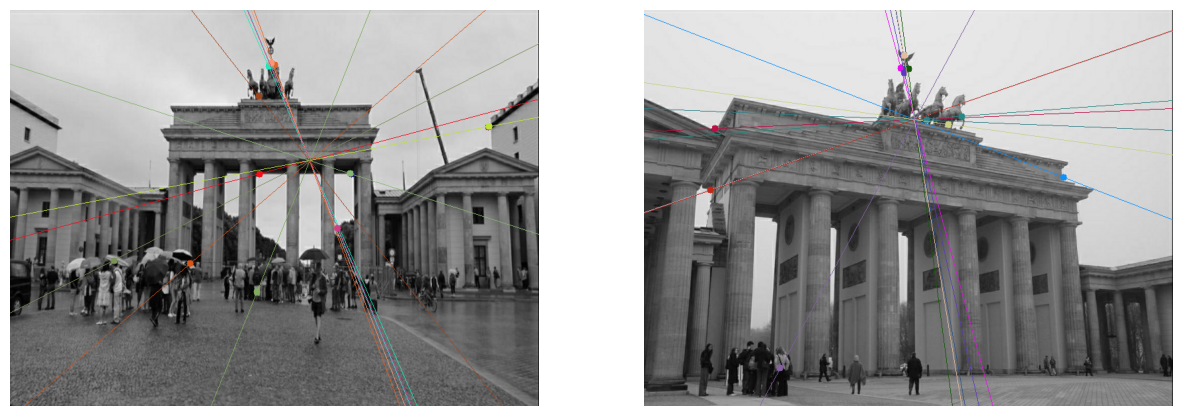

Rotation Matrix R:
 [[-0.91263841  0.4070683   0.03723609]
 [ 0.40031974  0.87163659  0.28283166]
 [ 0.08267547  0.27302938 -0.95844652]]

Translation Vector T:
 [[-0.09800758]
 [-0.18489571]
 [ 0.97785893]]


In [10]:
# your code here

# Now find fundamental matrix and essential matrix and use them to find the rotation and translation matrices

# Camera pose estimation involves determining the relative position and orientation (i.e., rotation and translation) of the camera between two views. This is typically done by estimating the essential matrix or fundamental matrix between two sets of matched keypoints, and then decomposing these matrices to recover the camera pose.

# So essentially:
# 1. Find the **fundamental matrix (F)** using the matched keypoints.
# 2. Decompose the **essential matrix (E)** into the rotation and translation components.
# 3. Use epipolar geometry to verify or refine the solution.
from scipy.spatial.transform import Rotation as R

def quaternion_to_rotation_matrix(q):
    r = R.from_quat([q[1], q[2], q[3], q[0]])
    return r.as_matrix()



points1 = np.array([first_image_kp[m.queryIdx].pt for m in bf_matches], dtype=np.float32)
points3 = np.array([third_image_kp[m.trainIdx].pt for m in bf_matches], dtype=np.float32)

F, mask = cv2.findFundamentalMat(points1, points3, cv2.FM_RANSAC, ransacReprojThreshold=1.0)

# We select only inlier points
points1 = points1[mask.ravel()==1]
points3 = points3[mask.ravel()==1]

#now we find the essential matrix
def generate_intrinsic_matrix(camera_params):
    """Generates the intrinsic matrix from the camera parameters"""
    fx = camera_params['focal_length_x'].values[0]
    fy = camera_params['focal_length_y'].values[0]
    cx = camera_params['principal_point_x'].values[0]
    cy = camera_params['principal_point_y'].values[0]

    return np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

K1 = generate_intrinsic_matrix(img1_camera_intrinsic_params)
K3 = generate_intrinsic_matrix(img3_camera_intrinsic_params)

E = K3.T @ F @ K1
_, R, T, _ = cv2.recoverPose(E, points1, points3, K1)

# R, T = None

#Draw the epipolar lines

img1_shape = preprocessed_images[0].shape
img3_shape = preprocessed_images[2].shape

lines1 = cv2.computeCorrespondEpilines(points3.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
epi_img1 = cv2.cvtColor(preprocessed_images[0], cv2.COLOR_GRAY2BGR)

lines3 = cv2.computeCorrespondEpilines(points1.reshape(-1, 1, 2), 1, F)
lines3 = lines3.reshape(-1, 3)
epi_img3 = cv2.cvtColor(preprocessed_images[2], cv2.COLOR_GRAY2BGR)

for r, pt1, pt3 in zip(lines1, points1, points3):
    color = tuple(np.random.randint(0, 255, 3).tolist())
    x0, y0 = map(int, [0, -r[2]/r[1]])
    x1, y1 = map(int, [img1_shape[1], -(r[2]+r[0]*img1_shape[1])/r[1]])
    epi_img1 = cv2.line(epi_img1, (x0, y0), (x1, y1), color, 1)
    epi_img1 = cv2.circle(epi_img1, tuple(map(int, pt1)), 5, color, -1)

for r, pt1, pt3 in zip(lines3, points1, points3):
    color = tuple(np.random.randint(0, 255, 3).tolist())
    x0, y0 = map(int, [0, -r[2]/r[1]])
    x1, y1 = map(int, [img3_shape[1], -(r[2]+r[0]*img3_shape[1])/r[1]])
    epi_img3 = cv2.line(epi_img3, (x0, y0), (x1, y1), color, 1)
    epi_img3 = cv2.circle(epi_img3, tuple(map(int, pt3)), 5, color, -1)

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(cv2.cvtColor(epi_img1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(122)
plt.imshow(cv2.cvtColor(epi_img3, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



# Print the Rotation and Translation matrices
print("Rotation Matrix R:\n", R)
print()
print("Translation Vector T:\n", T)

In [ ]:
#Method 2: Using perpective n point algorithm.

#no need for fundamental matrix or essential matrix here
#load .ply file
model_3d_path = "Dataset/brandenburg_gate/brandenburg_gate.ply"




### Linear Triangulation

Linear triangulation involves determining the 3D coordinates of a point in space based on its projections in two or more images taken from different viewpoints. Given two camera poses and the corresponding 2D feature points in both images, linear triangulation allows you to estimate the 3D coordinates of the points in the scene.

Compute the 3D coordinates of the matched feature points by solving the system of equations derived from the camera projection equations above.

In [ ]:
# ### Linear Triangulation


R1 = np.eye(3)
T1 = np.zeros((3, 1))

#r2 and t2 are the rotation and translation matrices of the second camera.
R2 = R
T2 = T

P1 = np.dot(K1, np.hstack((R1, T1)))
P2 = np.dot(K3, np.hstack((R2, T2)))

def linear_triangulation(P1,P2,points1,points2):

    num_points = points1.shape[0]
    points3d = []

    for i in range(num_points):
        # Points in homogeneous coordinates
        x1, y1 = points1[i][0], points1[i][1]
        x2, y2 = points2[i][0], points2[i][1]

        # Set up the system of equations (Ax = 0)
        A = np.array([
            x1 * P1[2, :] - P1[0, :],
            y1 * P1[2, :] - P1[1, :],
            x2 * P2[2, :] - P2[0, :],
            y2 * P2[2, :] - P2[1, :]
        ])

        # Solve using SVD (Least Squares)
        _, _, Vt = np.linalg.svd(A)
        X = Vt[-1]  # The last row of Vt is the solution
        X = X / X[3]  # Homogeneous to Cartesian coordinates

        # Store the 3D point
        points3d.append(X[:3])

    return np.array(points3d)

points3d = linear_triangulation(P1, P2, points1, points3)


print("3D Points:\n", points3d)




3D Points:
 [[-2.05450329e+00 -3.01927675e+00 -5.51800276e-03]
 [-2.05362436e+00 -3.01958264e+00 -5.52844638e-03]
 [-4.59171840e+01  1.03347256e+01 -1.06202638e-01]
 [-4.67078884e+01  1.05877348e+01 -1.06261192e-01]
 [-8.17108626e+01  2.13477028e+01 -9.96947073e-02]
 [-4.32692971e+01  9.52723049e+00 -1.00213549e-01]
 [-1.51229734e+00 -3.20079223e+00 -6.68916949e-03]
 [-8.20612367e+01  2.14551012e+01 -1.00002140e-01]
 [-5.38764339e+01  1.27500054e+01 -1.24283769e-01]
 [-1.15607366e+01 -5.14030646e-02 -1.61522171e-02]
 [-2.21403533e+00 -2.95796059e+00 -7.67676794e-03]
 [ 6.57626293e-01 -3.83504135e+00 -7.99834192e-03]
 [-1.90458415e-01 -3.55468971e+00 -4.93450864e-03]
 [ 1.30396252e-01 -3.66335192e+00 -6.18284785e-03]]


Visualise the 3D points obtained above. The results will probably not make any sense atm since we are only using two images, but this will help us in Task 2.

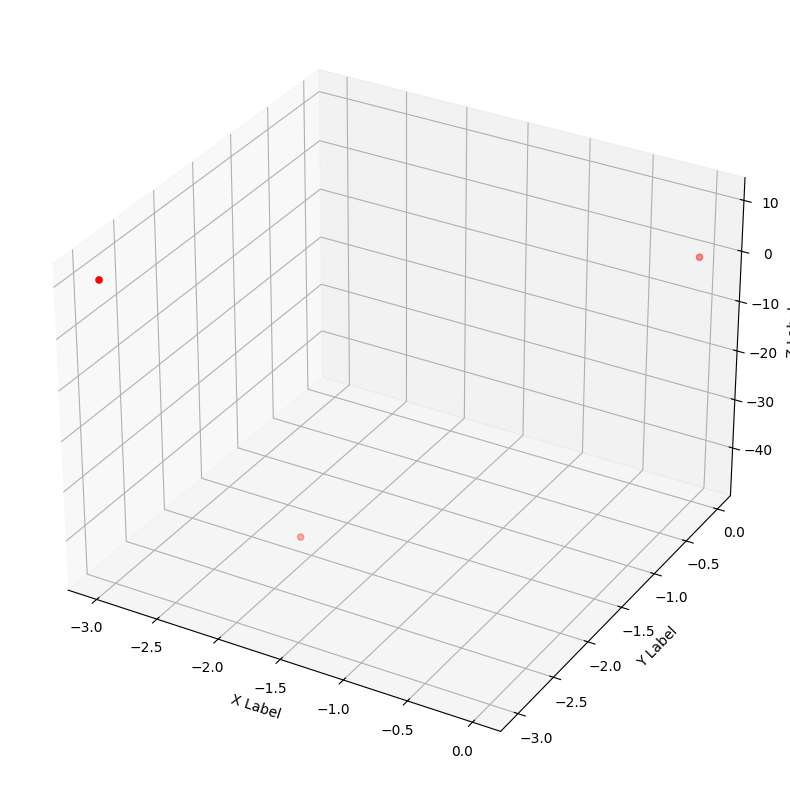

In [12]:
# your code here
# Visualise the 3D points obtained above. The results will probably not make any sense atm since we are only using two images, 
# but this will help us in Task 2.

# Visualize the 3D points in matplotlib
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points3d[0], points3d[1], points3d[2], c='r', marker='o')

ax.set_xlabel('X Label')

ax.set_ylabel('Y Label')

ax.set_zlabel('Z Label')

plt.show()
